# Multilabel Classification — DT · LSTM · BERT
One dataset (GoEmotions) for all models; PCA visualization; Confusion Matrices; summary table.

In [2]:

# !pip -q install datasets transformers accelerate evaluate torch tensorflow==2.16.1 scikit-learn pandas matplotlib --upgrade

import numpy as np, pandas as pd, matplotlib.pyplot as plt, time, warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset
from sklearn.preprocessing import MultiLabelBinarizer

ds = load_dataset("go_emotions")
label_names = ds["train"].features["labels"].feature.names
NUM_LABELS = len(label_names)

Xtr_txt = ds["train"]["text"]
Ytr_idx = ds["train"]["labels"]
Xte_txt = ds["test"]["text"]
Yte_idx = ds["test"]["labels"]

mlb = MultiLabelBinarizer(classes=list(range(NUM_LABELS)))
Y_train = mlb.fit_transform(Ytr_idx)
Y_test  = mlb.transform(Yte_idx)

print(f"Labels: {NUM_LABELS} — {label_names[:5]} ...")
print("Train/Test:", len(Xtr_txt), len(Xte_txt))


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Labels: 28 — ['admiration', 'amusement', 'anger', 'annoyance', 'approval'] ...
Train/Test: 43410 5427


## 1) Decision Tree (One-vs-Rest)

In [3]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2)
Xtr = tfidf.fit_transform(Xtr_txt)
Xte = tfidf.transform(Xte_txt)

svd_300 = TruncatedSVD(n_components=300, random_state=42)
Xtr300 = svd_300.fit_transform(Xtr)
Xte300 = svd_300.transform(Xte)

dt = OneVsRestClassifier(DecisionTreeClassifier(random_state=42, min_samples_leaf=2))
t0 = time.time()
dt.fit(Xtr300, Y_train)
fit_dt = time.time() - t0

t1 = time.time()
Yp_dt = dt.predict(Xte300)
pred_dt = time.time() - t1

f1_micro_dt = f1_score(Y_test, Yp_dt, average="micro", zero_division=0)
f1_macro_dt = f1_score(Y_test, Yp_dt, average="macro", zero_division=0)
print(f"DT: fit {fit_dt:.1f}s pred {pred_dt:.1f}s F1_micro={f1_micro_dt:.3f} F1_macro={f1_macro_dt:.3f}")


DT: fit 2932.1s pred 0.1s F1_micro=0.312 F1_macro=0.201


## 2) LSTM (Keras, BiLSTM)

In [4]:

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score, precision_score, recall_score

max_words = 40000
max_len = 128

tok = Tokenizer(num_words=max_words, oov_token="<unk>")
tok.fit_on_texts(Xtr_txt)
Xtr_seq = pad_sequences(tok.texts_to_sequences(Xtr_txt), maxlen=max_len)
Xte_seq = pad_sequences(tok.texts_to_sequences(Xte_txt),  maxlen=max_len)

num_labels = Y_train.shape[1]
model_lstm = models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(256, activation="relu"),
    layers.Dense(num_labels, activation="sigmoid")
])
model_lstm.compile(optimizer="adam", loss="binary_crossentropy")

t0 = time.time()
model_lstm.fit(Xtr_seq, Y_train, epochs=2, batch_size=128, validation_split=0.1, verbose=1)
fit_lstm = time.time() - t0

t1 = time.time()
probs = model_lstm.predict(Xte_seq, verbose=0)
Yp_lstm = (probs>0.5).astype(int)
pred_lstm = time.time() - t1

f1_micro_lstm = f1_score(Y_test, Yp_lstm, average="micro", zero_division=0)
f1_macro_lstm = f1_score(Y_test, Yp_lstm, average="macro", zero_division=0)
print(f"LSTM: fit {fit_lstm:.1f}s pred {pred_lstm:.1f}s F1_micro={f1_micro_lstm:.3f} F1_macro={f1_macro_lstm:.3f}")


Epoch 1/2
306/306 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.1986 - val_loss: 0.1230
Epoch 2/2
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.1155 - val_loss: 0.1118
LSTM: fit 23.8s pred 1.4s F1_micro=0.441 F1_macro=0.172


## 3) BERT (bert-base-uncased)

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, Sequence, Value
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score

model_name = "bert-base-uncased"
tok = AutoTokenizer.from_pretrained(model_name)

train_df = pd.DataFrame({"text": Xtr_txt, "labels": list(Y_train)})
test_df  = pd.DataFrame({"text": Xte_txt, "labels": list(Y_test)})
ds_tr = Dataset.from_pandas(train_df)
ds_te = Dataset.from_pandas(test_df)

def tokenize(batch):
    enc = tok(batch["text"], truncation=True, padding="max_length", max_length=128)
    enc["labels"] = np.asarray(batch["labels"], dtype=np.float32)  # <-- float32
    return enc

ds_tr = ds_tr.map(tokenize, batched=True, remove_columns=["text"])
ds_te = ds_te.map(tokenize, batched=True, remove_columns=["text"])

ds_tr = ds_tr.cast_column("labels", Sequence(Value("float32")))
ds_te = ds_te.cast_column("labels", Sequence(Value("float32")))

model_bert = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_names), problem_type="multi_label_classification"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1/(1+np.exp(-logits))
    preds = (probs > 0.5).astype(int)
    return {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

args = TrainingArguments(
    output_dir="bert-goemotions",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    eval_strategy="epoch",
    save_strategy="no",
    fp16=True,
    logging_steps=100,
    report_to="none",
)

trainer = Trainer(
    model=model_bert,
    args=args,
    train_dataset=ds_tr,
    eval_dataset=ds_te,
    tokenizer=tok,
    compute_metrics=compute_metrics,
)

import time
t0 = time.time(); trainer.train(); fit_bert = time.time() - t0
t1 = time.time(); eval_res = trainer.evaluate(); pred_bert = time.time() - t1

print(
    f"BERT: fit {fit_bert:.1f}s pred {pred_bert:.1f}s "
    f"F1_micro={eval_res['eval_f1_micro']:.3f} F1_macro={eval_res['eval_f1_macro']:.3f}"
)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/43410 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5427 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Micro,Recall Micro
1,0.087700,0.087145,0.535660,0.299393,0.756048,0.414757


BERT: fit 338.2s pred 11.1s F1_micro=0.536 F1_macro=0.299


## 4) SVD→PCA 2D visualization (TF‑IDF of test set)

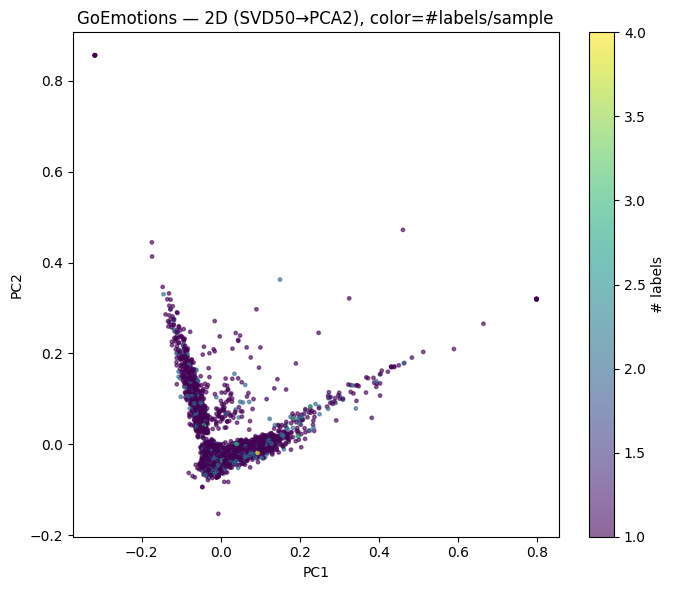

In [9]:

from sklearn.decomposition import TruncatedSVD, PCA

svd_50 = TruncatedSVD(n_components=50, random_state=42)
Xvis50 = svd_50.fit_transform(Xte)
pca2 = PCA(n_components=2, random_state=42)
Xvis2 = pca2.fit_transform(Xvis50)

label_counts = Y_test.sum(axis=1)
plt.figure(figsize=(7,6))
plt.scatter(Xvis2[:,0], Xvis2[:,1], c=label_counts, s=6, alpha=0.6)
plt.title("GoEmotions — 2D (SVD50→PCA2), color=#labels/sample")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(label="# labels")
plt.tight_layout(); plt.show()


## 5) Confusion Matrices (top‑10 frequent labels)

BERT (computed): F1_micro=0.536  F1_macro=0.299

=== Confusion Matrices — Decision Tree (top-10) ===


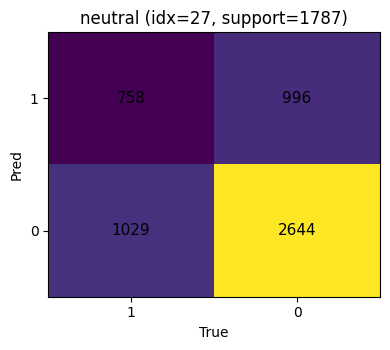

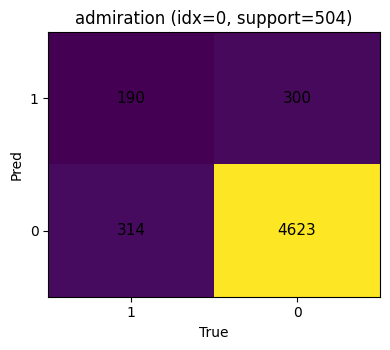

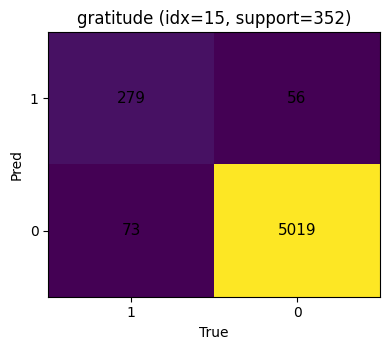

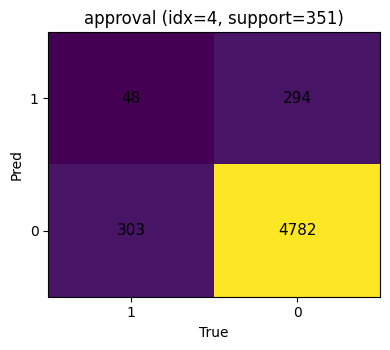

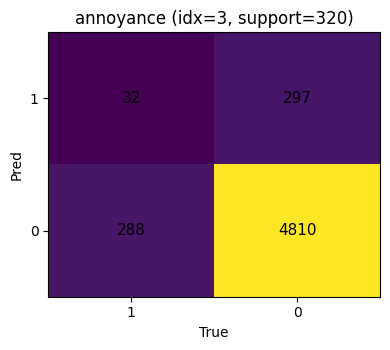

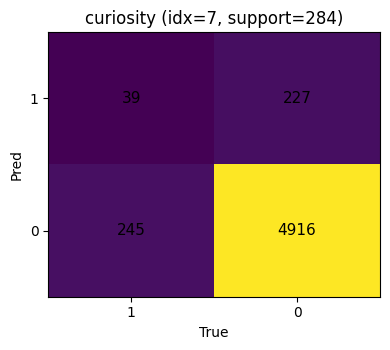

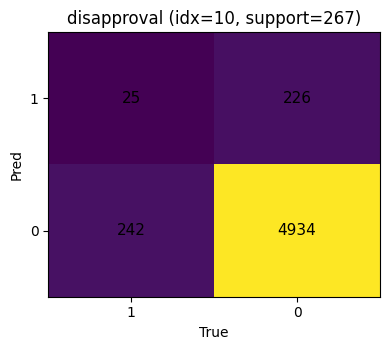

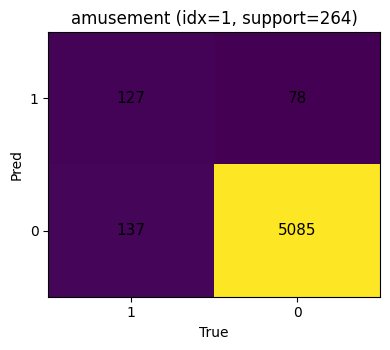

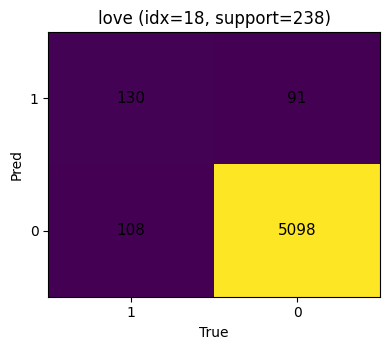

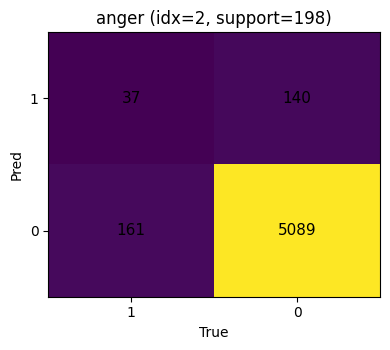


=== Confusion Matrices — LSTM (top-10) ===


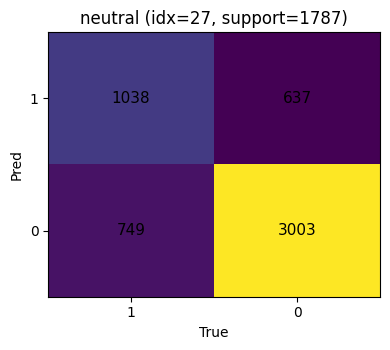

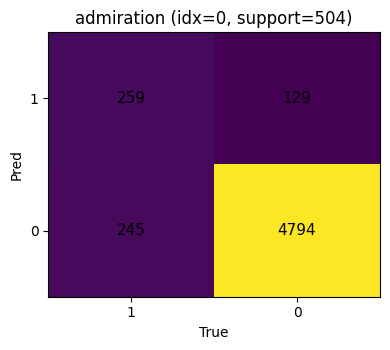

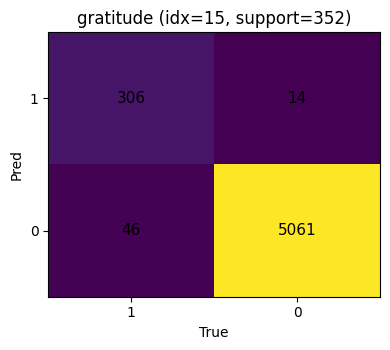

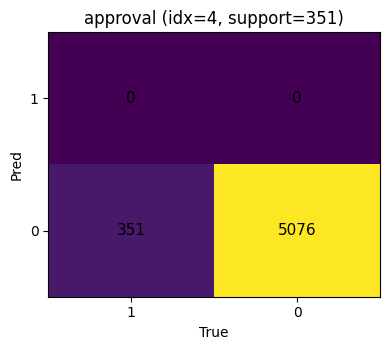

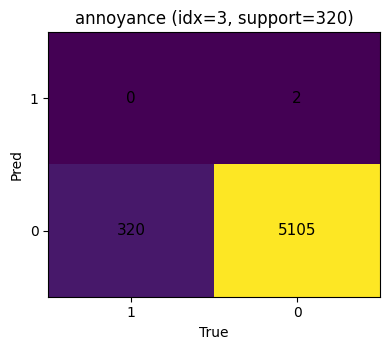

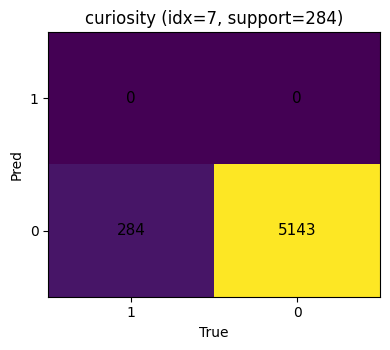

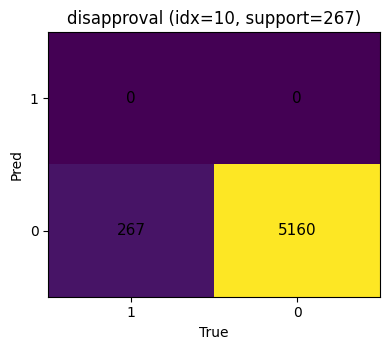

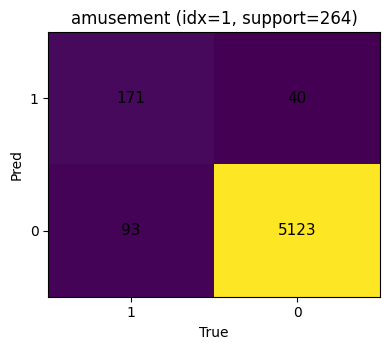

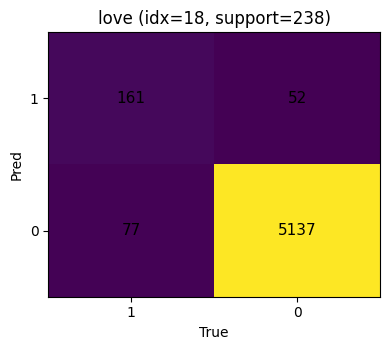

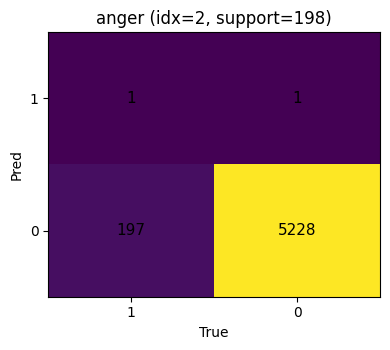


=== Confusion Matrices — BERT (top-10) ===


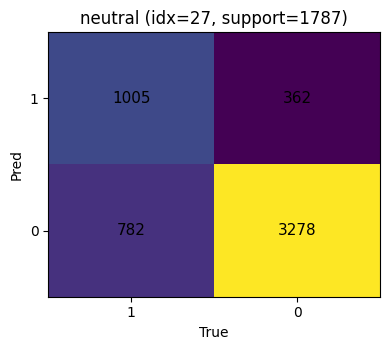

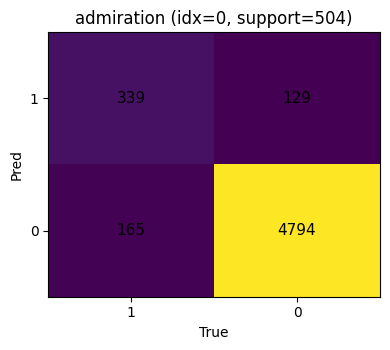

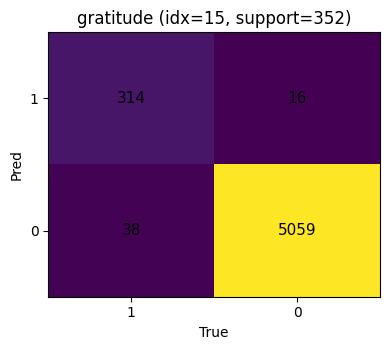

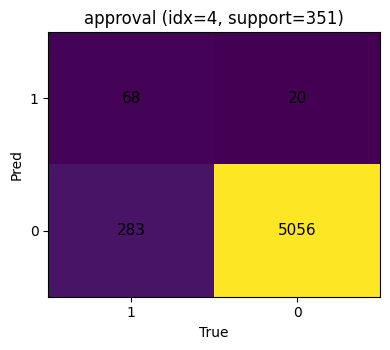

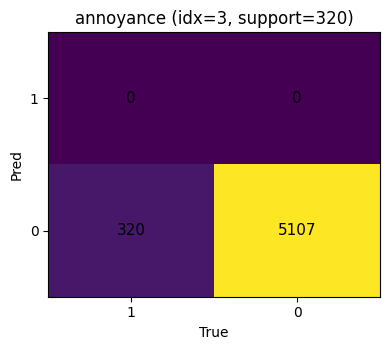

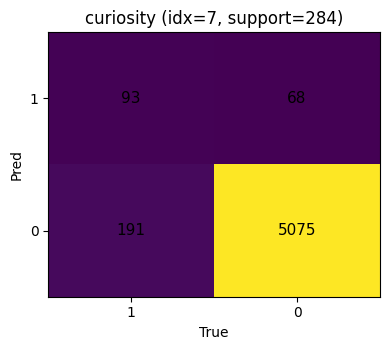

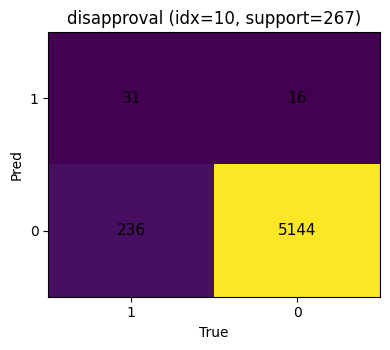

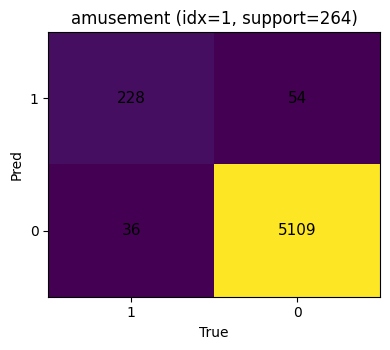

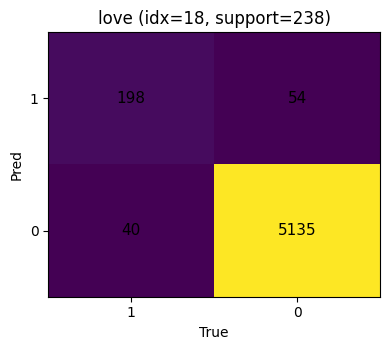

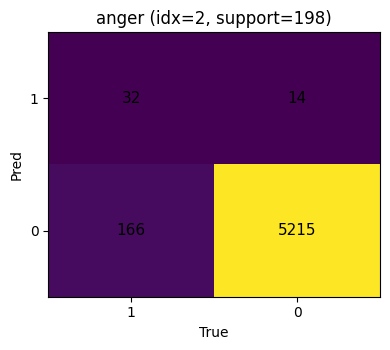

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

def plot_cm_single(cm, title=""):
    tn, fp, fn, tp = cm.ravel()
    m = np.array([[tp, fp],
                  [fn, tn]], dtype=int)

    plt.figure(figsize=(4, 3.6))
    plt.imshow(m, aspect="auto")
    plt.title(title)
    plt.xlabel("True")
    plt.ylabel("Pred")
    plt.xticks([0,1], ["1", "0"])
    plt.yticks([0,1], ["1", "0"])

    for (i, j), val in np.ndenumerate(m):
        plt.text(j, i, str(val), ha="center", va="center", fontsize=11)

    plt.tight_layout()
    plt.show()

def plot_cm_set(name, Y_true, Y_pred, label_names, top_k=10):
    freq = Y_true.sum(axis=0)
    top_labels = np.argsort(freq)[::-1][:top_k]
    mlcm = multilabel_confusion_matrix(Y_true, Y_pred)

    print(f"\n=== Confusion Matrices — {name} (top-{top_k}) ===")
    for idx in top_labels:
        cm = mlcm[idx]
        support = int(freq[idx])
        title = f"{label_names[idx]} (idx={idx}, support={support})"
        plot_cm_single(cm, title=title)

preds = trainer.predict(ds_te).predictions
probs = 1/(1+np.exp(-preds))
Yp_bert = (probs > 0.5).astype(int)
f1_micro_bert = f1_score(Y_test, Yp_bert, average="micro", zero_division=0)
f1_macro_bert = f1_score(Y_test, Yp_bert, average="macro", zero_division=0)
precision_micro_bert = precision_score(Y_test, Yp_bert, average="micro", zero_division=0)
recall_micro_bert    = recall_score(Y_test, Yp_bert, average="micro", zero_division=0)

print(f"BERT (computed): F1_micro={f1_micro_bert:.3f}  F1_macro={f1_macro_bert:.3f}")

plot_cm_set("Decision Tree", Y_test, Yp_dt, label_names, top_k=10)
plot_cm_set("LSTM",          Y_test, Yp_lstm, label_names, top_k=10)
plot_cm_set("BERT",          Y_test, Yp_bert, label_names, top_k=10)

## 6) Comparative table

In [14]:

summary = pd.DataFrame([
    {"Approach":"Classical ML","Method":"Decision Tree (OvR)","dataset":"GoEmotions",
     "amount of data": f"{len(Xtr_txt)} train / {len(Xte_txt)} test; {len(tfidf.get_feature_names_out())} tfidf feats; {NUM_LABELS} labels",
     "speed": f"{fit_dt:.1f} s","Accuracy (F1_micro)": f"{f1_micro_dt:.3f}"},
    {"Approach":"Neural Networks","Method":"LSTM (BiLSTM)","dataset":"GoEmotions",
     "amount of data": f"{len(Xtr_txt)} train / {len(Xte_txt)} test; {NUM_LABELS} labels",
     "speed": f"{fit_lstm:.1f} s","Accuracy (F1_micro)": f"{f1_micro_lstm:.3f}"},
    {"Approach":"Transformers","Method":"BERT (bert-base-uncased)","dataset":"GoEmotions",
     "amount of data": f"{len(Xtr_txt)} train / {len(Xte_txt)} test; {NUM_LABELS} labels",
     "speed": f"{fit_bert:.1f} s","Accuracy (F1_micro)": f"{f1_micro_bert:.3f}"},
])
summary


,Approach,Method,dataset,amount of data,speed,Accuracy (F1_micro)
0,Classical ML,Decision Tree (OvR),GoEmotions,43410 train / 5427 test; 50000 tfidf feats; 28...,2932.1 s,0.312
1,Neural Networks,LSTM (BiLSTM),GoEmotions,43410 train / 5427 test; 28 labels,23.8 s,0.441
2,Transformers,BERT (bert-base-uncased),GoEmotions,43410 train / 5427 test; 28 labels,338.2 s,0.536
